In [2]:
%matplotlib inline
from pathlib import Path
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model, datasets
import matplotlib.pylab as plt
from utilities import *

In [3]:
DATA = Path('.').resolve().parent/'data'
ebay_df = pd.read_csv(DATA/'eBayAuctions.csv')
ebay_df.head(2)

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [4]:
ebay_df.columns = [s.strip().replace('?', '') for s in ebay_df.columns]
ebay_df.Category = ebay_df.Category.astype('category')
ebay_df.currency = ebay_df.currency.astype('category')
ebay_df.endDay = ebay_df.endDay.astype('category')
ebay_df.dtypes

Category        category
currency        category
sellerRating       int64
Duration           int64
endDay          category
ClosePrice       float64
OpenPrice        float64
Competitive        int64
dtype: object

In [5]:
# convert categorical variables into indicator and drop the first column of each of them
ebay_df = pd.get_dummies(ebay_df, prefix_sep='_')
ebay_df.Competitive = ebay_df.Competitive.astype('category')
ebay_df = sm.add_constant(ebay_df, prepend=True)
ebay_df.drop(columns=['Category_Antique/Art/Craft', 'currency_EUR', 'endDay_Fri'], inplace=True)
ebay_df.columns

Index(['const', 'sellerRating', 'Duration', 'ClosePrice', 'OpenPrice',
       'Competitive', 'Category_Automotive', 'Category_Books',
       'Category_Business/Industrial', 'Category_Clothing/Accessories',
       'Category_Coins/Stamps', 'Category_Collectibles', 'Category_Computer',
       'Category_Electronics', 'Category_EverythingElse',
       'Category_Health/Beauty', 'Category_Home/Garden', 'Category_Jewelry',
       'Category_Music/Movie/Game', 'Category_Photography',
       'Category_Pottery/Glass', 'Category_SportingGoods',
       'Category_Toys/Hobbies', 'currency_GBP', 'currency_US', 'endDay_Mon',
       'endDay_Sat', 'endDay_Sun', 'endDay_Thu', 'endDay_Tue', 'endDay_Wed'],
      dtype='object')

In [6]:
train_df = ebay_df.sample(frac=0.6, random_state=202)
valid_df = ebay_df.drop(train_df.index)

# Question 1 (5 points) logistic regression with all. Interpret predictor in output. How were they derived from the columns in the csv file?

In [7]:
logit_reg = sm.GLM(train_df['Competitive'], train_df.drop(columns=['Competitive']), family=sm.families.Binomial())
logit_result = logit_reg.fit()
print(logit_result.summary())

C:\Jenny\DataScience\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Jenny\DataScience\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:932: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Jenny\DataScience\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:933: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
C:\Jenny\DataScience\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:933: RuntimeWarning: invalid value encountered in add
  n * np.log(1 - mu)) * var_weights


                 Generalized Linear Model Regression Results                  
Dep. Variable:            Competitive   No. Observations:                 1183
Model:                            GLM   Df Residuals:                     1153
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 07 Jul 2018   Deviance:                          nan
Time:                        00:06:53   Pearson chi2:                 1.45e+14
No. Iterations:                   100   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.3568      0.537     -0.664      0.506      -1.409       0

We can see endDay_Mon is competitive, open price significantly affect the result, different category also has obvious effects. some independent variables changed to category and dummy columns.

# Question 2 (3 points) predict validation set. accuracy? confusion matrix

In [8]:
logit_reg_pred = logit_result.predict(valid_df.drop(columns=['Competitive']))

printConfusionMatrix(valid_df['Competitive'], [1 if p > 0.5 else 0 for p in logit_reg_pred])

Confusion Matrix (Accuracy 0.7820)

         Prediction
Reference   0   1
        0 294  74
        1  98 323


# Question 3 (5 points) logistic excluding closing price. compare accuracy? confusion matrix, lift chart, and decile chart.

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Competitive   No. Observations:                 1183
Model:                            GLM   Df Residuals:                     1154
Model Family:                Binomial   Df Model:                           28
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -729.00
Date:                Sat, 07 Jul 2018   Deviance:                       1458.0
Time:                        00:07:04   Pearson chi2:                 1.22e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.7689      0.446      1.724      0.085      -0.105       1

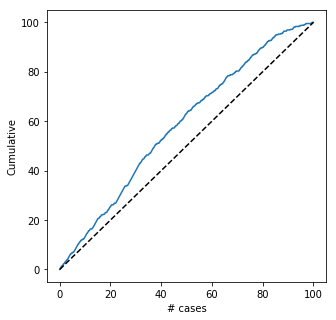

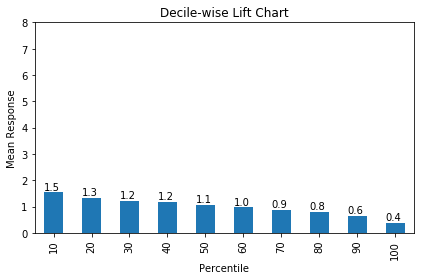

In [9]:
logit_reg_nocloseprice = sm.GLM(train_df['Competitive'], train_df.drop(columns=['Competitive', 'ClosePrice']), 
                                family=sm.families.Binomial())
logit_result_nocloseprice = logit_reg_nocloseprice.fit()
print(logit_result_nocloseprice.summary())
logit_reg_pred_nocloseprice = logit_result_nocloseprice.predict(valid_df.drop(columns=['Competitive', 'ClosePrice']))

printConfusionMatrix(valid_df['Competitive'], [1 if p > 0.5 else 0 for p in logit_reg_pred_nocloseprice])

df = pd.DataFrame({'actual': valid_df.Competitive.astype('int'), 'predicted': logit_reg_pred_nocloseprice})
df = df.sort_values(by=['predicted'], ascending=False).reset_index(drop=True)

# note the addition of the 0 value at the front of the cumulative sum
cumActual = pd.concat([pd.Series([0]), 100 * df.actual.cumsum() / df.actual.sum()])
lift_df = pd.DataFrame({'percTested': [100 * i / len(df) for i in range(len(df) + 1)],
                        'percCumActual': cumActual})

ax = lift_df.plot(x='percTested', y='percCumActual', legend=False, figsize=[5, 5])
ax.plot([0, 100], [0, 100], linestyle='--', color='k')
ax.set_xlabel('# cases')
ax.set_ylabel('Cumulative')
plt.show()

groups = [int(10 * i / len(df.predicted)) for i in range(len(df.predicted))]
meanPercentile = df.predicted.groupby(groups).mean()
meanResponse = meanPercentile / df.predicted.mean()
meanResponse.index = (meanResponse.index + 1) * 10

ax = meanResponse.plot.bar(color='C0')
ax.set_ylim(0, 8)
ax.set_xlabel('Percentile')
ax.set_ylabel('Mean Response')
ax.set_title('Decile-wise Lift Chart')

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x(), p.get_height() + 0.1))

plt.tight_layout() 
plt.show()

# Question 4 (2 points) Interpret the meaning of the coefficient for closing price. Does closing price have a practical significance? 

                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
ClosePrice                        0.1329      0.013      9.843      0.000       0.106       0.159

coefficient for closing price p value shows the signifance. But since the closing price is after bid, it does not have a practical significance.